In [1]:
library(data.table)
library(ggplot2)
library(dplyr)
library(ggrepel)
library(tidyr)
set.seed(42)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# function to load xlsx with multiple sheets
multiplesheets <- function(fname) {
   
  # getting info about all excel sheets
  sheets <- readxl::excel_sheets(fname)
  tibble <- lapply(sheets, function(x) readxl::read_excel(fname, sheet = x))
  data_frame <- lapply(tibble, as.data.frame)
    
  # assigning names to data frames
  names(data_frame) <- sheets
    
  data_frame
}

In [3]:
# function to construct a volcano plot from a df with pvals, avg_log2FC, and gene/TF names
volcanoplot <- function(df,
                        title,
                        label_genes,
                        pval_colname = 'fdr',
                        FC_colname = 'coef',
                        label_colname = 'primerid',
                        ep = 1e-400,
                        p_cutoff = 0.05,
                        FC_cutoff = c(-1, 1),
                        max_overlaps = 20,
                        label_uplim = c(2,4),
                        label_downlim = c(-2,-4),
                        xlabel = 'Coef',
                        ylabel = '-log(FDR)') {
   
  # calculate -log10 pval (add epsilon to account for 0s)
  #ep <- min(df[[pval_colname]][df[[pval_colname]] != 0])
  df$log10_pval <- -log10(df[[pval_colname]] + ep) 
  
  # add column for points above or below FC cutoffs
  df$Key <- 'NOT SIGNIFICANT'
  df$Key[df[[FC_colname]] > FC_cutoff[2] & df[[pval_colname]] < p_cutoff] <- 'UP'
  df$Key[df[[FC_colname]] < FC_cutoff[1] & df[[pval_colname]] < p_cutoff] <- 'DOWN'
  
  # add label column: label the `label_n' most extreme values
  df$to_label <- FALSE
  df <- df %>% mutate(to_label = ifelse(.data[[label_colname]] %in% label_genes, TRUE, FALSE))
  
  df$label_name <- df[[label_colname]]
  df$label_name <- sub("_.*", "", df$label_name)
  df$label_name[!df$to_label] <- NA

  #plot
  ggplot(data=df, aes(x=.data[[FC_colname]], y=log10_pval, col=Key, label = label_name, alpha = Key)) +
    geom_point() +
    theme_bw() +
    theme(
        panel.border = element_blank(), panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line = element_blank()
        ) +
    geom_text_repel(data = subset(df, df$Key == 'UP'),
                    max.overlaps = max_overlaps, 
                    xlim = label_uplim,
                    colour = 'black',
                    hjust = 0,
                    size = 4,
                    force = 0.5,
                    direction="y",
                    segment.size = 0.2) +
    geom_text_repel(data = subset(df, df$Key == 'DOWN'),
                    max.overlaps = max_overlaps, 
                    xlim = label_downlim,
                    colour = 'black',
                    hjust = 0,
                    size = 4,
                    force = 0.5,
                    direction="y",
                    segment.size = 0.2) +
    geom_hline(yintercept=-log10(p_cutoff + ep), linetype = 2) +
    ggtitle(title) +
    xlab(xlabel) +
    ylab(ylabel) +
    theme(
    plot.title = element_text(size = 20, face = "bold"),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x = element_text(size = 12),
    axis.text.y = element_text(size = 12),
  )+
    scale_color_manual(values=c('#7f7f7f', 'lightgrey', '#F8766D')) +
    scale_alpha_manual(values = c(UP = 1, DOWN = 1, `NOT SIGNIFICANT` = 0.4))+
    guides(color = "none", alpha = "none")
}

In [4]:
genes_to_label_function <- function(df) {
  
  # Split the 'name' column and keep only the first part (before the underscore)
  #df$name <- sub("_.*", "", df$name)
  
  # Assign DGE categories based on MeanDiff and pval
  df$DGE <- "NO"
  df$DGE[df$MeanDiff > 0 & df$pval < 0.05] <- "UP"
  df$DGE[df$MeanDiff < 0 & df$pval < 0.05] <- "DOWN"
  
  # Compute -log10(pvals) and handle zero p-values by replacing them with NaN
  df$`-log10(pvals)` <- -log10(ifelse(df$pval == 0, NA, df$pval))
  
  # Remove rows with NA or Inf values
  df <- df[!is.na(df$`-log10(pvals)`), ]
  df <- df[!is.infinite(df$`-log10(pvals)`), ]
  
  # Separate into 'UP' and 'DOWN' DataFrames and select top genes
  df_up <- df[df$DGE == "UP", ]
  df_up <- df_up[order(df_up$pval), ][1:25, ]
  df_down <- df[df$DGE == "DOWN", ]
  df_down <- df_down[order(df_down$pval), ][1:25, ]
  
  # Combine the top 'UP' and 'DOWN' genes
  selected_genes <- rbind(df_up, df_down)
  
  return(as.list(selected_genes$name))
}


# Neutrophils

In [5]:
diffchromvar_save_path <- '/athena/josefowiczlab/scratch/rer4011/projects/MAZ_andrew_data/results/DGE/chromvar_BoneMarrow/HSC_MPP_diffchromvar_res.xlsx'
diffchromvar <- multiplesheets(diffchromvar_save_path)
celltype <- 'HSC_MPP'

In [6]:
names(diffchromvar)

[1] "BG-pre_VS_BG-BCG"  "BG-pre_VS_PBS"     "BG-pre_VS_BG-post"
[4] "BG-BCG_VS_PBS"     "BG-BCG_VS_BG-post" "PBS_VS_BG-post"

Warning message:
“Removed 149 rows containing missing values (`geom_text_repel()`).”
Warning message:
“Removed 240 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 7 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


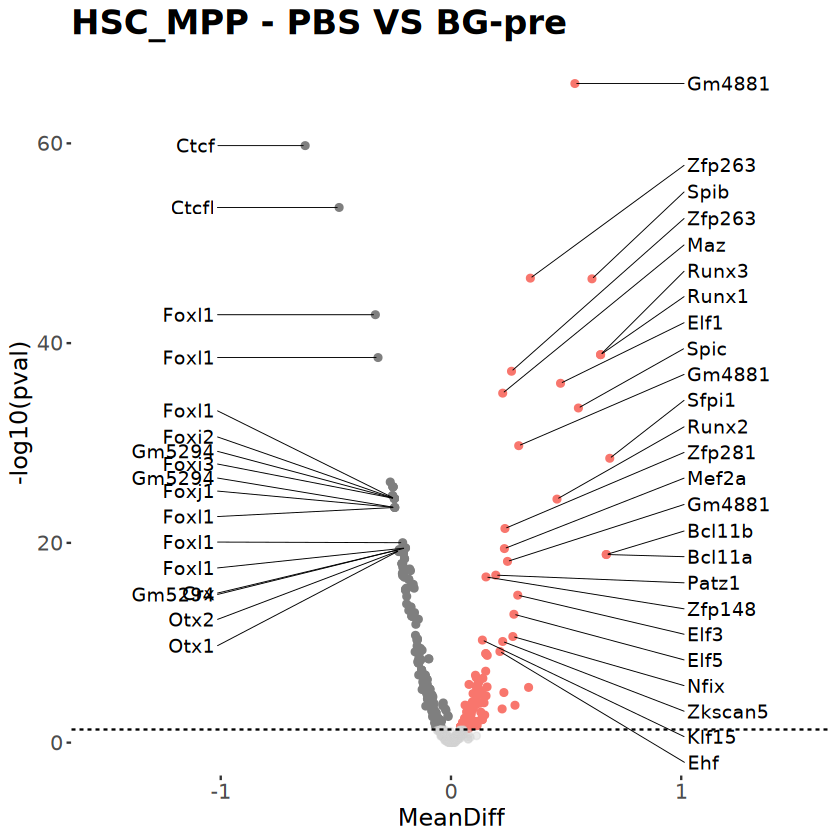

In [10]:
#df <- diffchromvar[['PBS_VS_B-Glucan-before']]
df <- diffchromvar[['BG-pre_VS_BG-BCG']]

genes_to_label <- genes_to_label_function(df)

p1 <- volcanoplot(df,
            paste0(celltype,' - PBS VS BG-pre'),
            label_genes = genes_to_label,
            pval_colname = 'pval',
            FC_colname = 'MeanDiff',
            label_colname = 'name',
            ep = 1e-400,
            p_cutoff = 0.05,
            FC_cutoff = c(0,0),
            max_overlaps = 20,
            label_uplim = c(1,3),
            label_downlim = c(-1,-2),
            xlabel = 'MeanDiff',
            ylabel = '-log10(pval)') +
            xlim(-1.5,1.5)
p1

Warning message:
“Removed 149 rows containing missing values (`geom_text_repel()`).”
Warning message:
“Removed 240 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 7 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


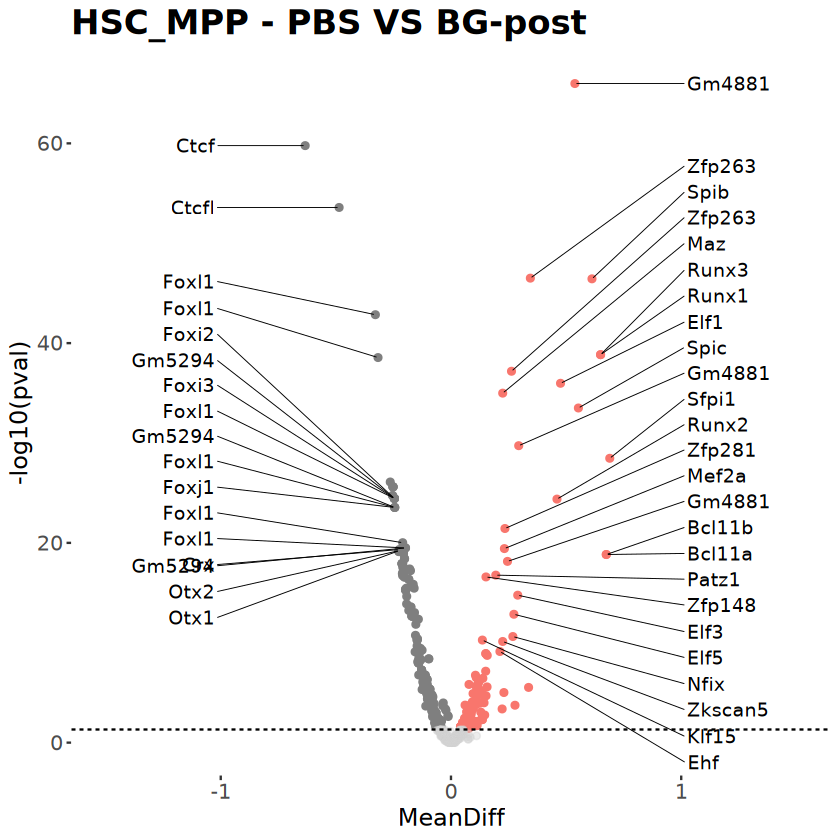

In [12]:
df <- diffchromvar[['BG-pre_VS_BG-BCG']]

genes_to_label <- genes_to_label_function(df)

p2 <- volcanoplot(df,
            paste0(celltype,' - PBS VS BG-post'),
            label_genes = genes_to_label,
            pval_colname = 'pval',
            FC_colname = 'MeanDiff',
            label_colname = 'name',
            ep = 1e-400,
            p_cutoff = 0.05,
            FC_cutoff = c(0,0),
            max_overlaps = 20,
            label_uplim = c(1,3),
            label_downlim = c(-1,-2),
            xlabel = 'MeanDiff',
            ylabel = '-log10(pval)') +
            xlim(-1.5,1.5)
p2

Warning message:
“Removed 115 rows containing missing values or values outside the scale range (`geom_text_repel()`).”
Warning message:
“Removed 21 rows containing missing values or values outside the scale range (`geom_text_repel()`).”


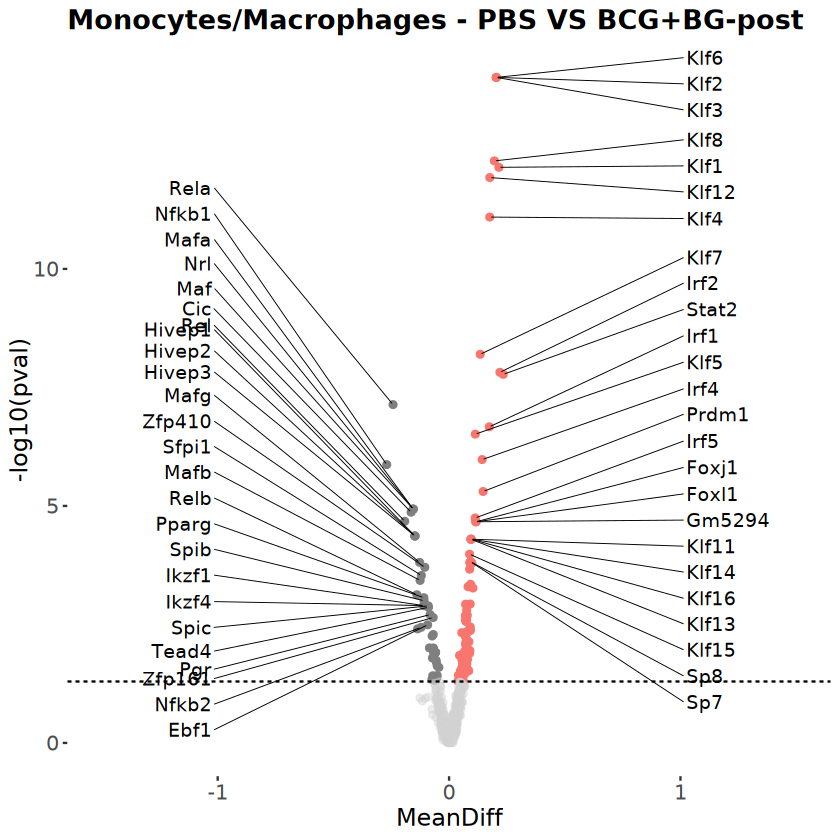

In [63]:
df <- diffchromvar[['PBS_VS_B-Glucan-BCG-after']]

genes_to_label <- genes_to_label_function(df)

p3 <- volcanoplot(df,
            paste0(celltype,' - PBS VS BCG+BG-post'),
            label_genes = genes_to_label,
            pval_colname = 'pval',
            FC_colname = 'MeanDiff',
            label_colname = 'name',
            ep = 1e-400,
            p_cutoff = 0.05,
            FC_cutoff = c(0,0),
            max_overlaps = 20,
            label_uplim = c(1,3),
            label_downlim = c(-1,-2),
            xlabel = 'MeanDiff',
            ylabel = '-log10(pval)') +
            xlim(-1.5,1.5)
p3

Warning message:
“Removed 178 rows containing missing values or values outside the scale range (`geom_text_repel()`).”
Warning message:
“Removed 111 rows containing missing values or values outside the scale range (`geom_text_repel()`).”


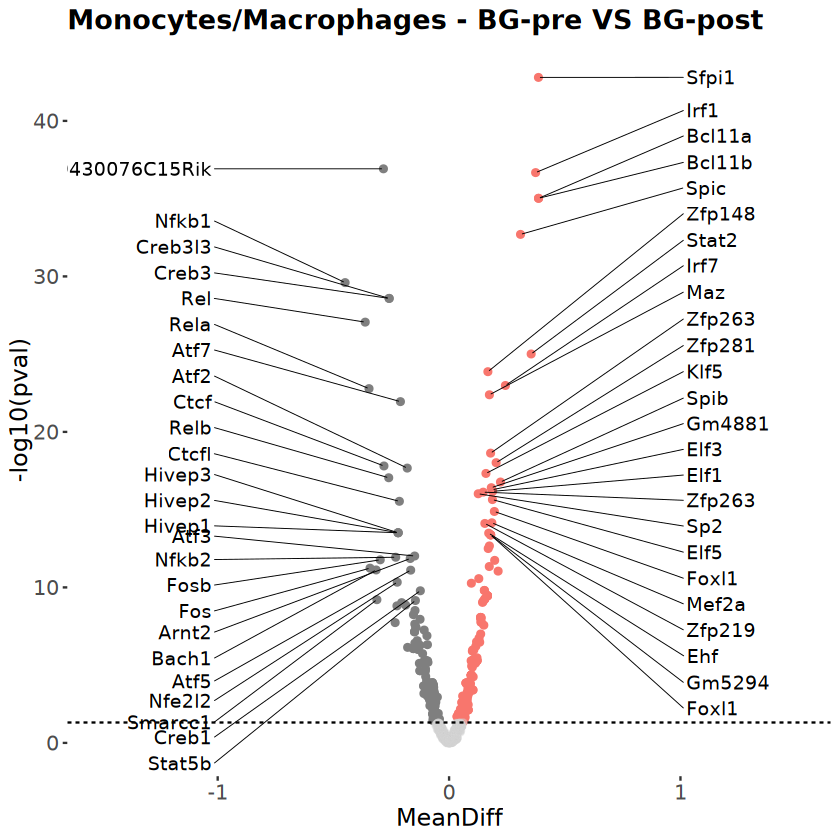

In [64]:
df <- diffchromvar[['B-Glucan-before_VS_B-Glucan-after']]

genes_to_label <- genes_to_label_function(df)

p4 <- volcanoplot(df,
            paste0(celltype,' - BG-pre VS BG-post'),
            label_genes = genes_to_label,
            pval_colname = 'pval',
            FC_colname = 'MeanDiff',
            label_colname = 'name',
            ep = 1e-400,
            p_cutoff = 0.05,
            FC_cutoff = c(0,0),
            max_overlaps = 20,
            label_uplim = c(1,3),
            label_downlim = c(-1,-2),
            xlabel = 'MeanDiff',
            ylabel = '-log10(pval)') +
            xlim(-1.5,1.5)
p4

Warning message:
“Removed 190 rows containing missing values or values outside the scale range (`geom_text_repel()`).”
Warning message:
“Removed 130 rows containing missing values or values outside the scale range (`geom_text_repel()`).”
Warning message:
“ggrepel: 5 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


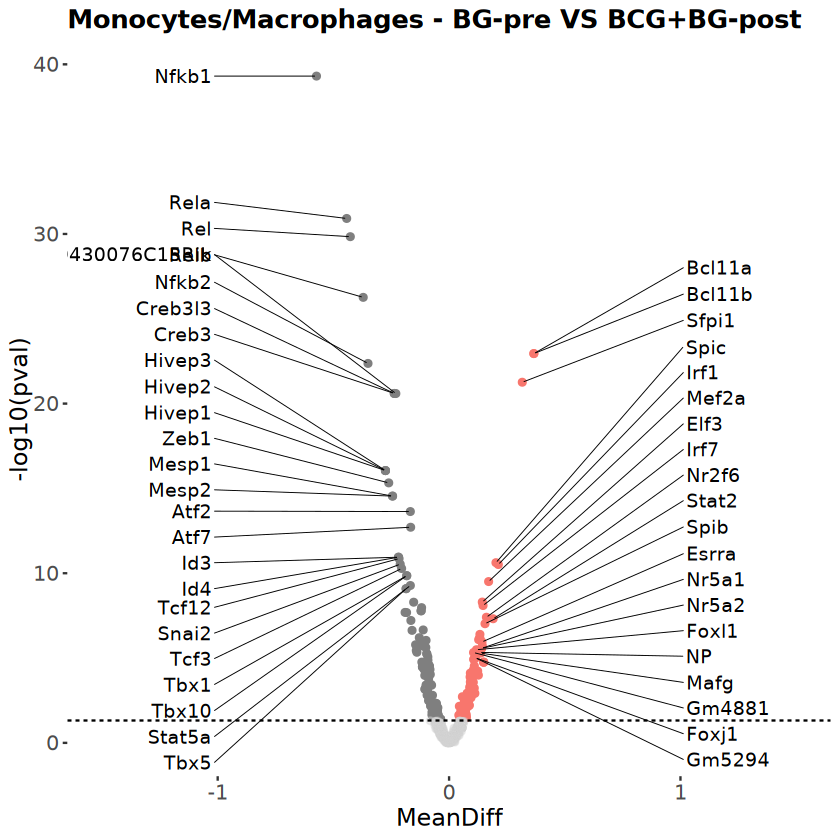

In [71]:
df <- diffchromvar[['B-Glucan-before_VS_B-Glucan-BCG-after']]

genes_to_label <- genes_to_label_function(df)

p5 <- volcanoplot(df,
            paste0(celltype,' - BG-pre VS BCG+BG-post'),
            label_genes = genes_to_label,
            pval_colname = 'pval',
            FC_colname = 'MeanDiff',
            label_colname = 'name',
            ep = 1e-400,
            p_cutoff = 0.05,
            FC_cutoff = c(0,0),
            max_overlaps = 20,
            label_uplim = c(1,3),
            label_downlim = c(-1,-2),
            xlabel = 'MeanDiff',
            ylabel = '-log10(pval)') +
            xlim(-1.5,1.5)
p5

Warning message:
“Removed 107 rows containing missing values or values outside the scale range (`geom_text_repel()`).”
Warning message:
“Removed 156 rows containing missing values or values outside the scale range (`geom_text_repel()`).”


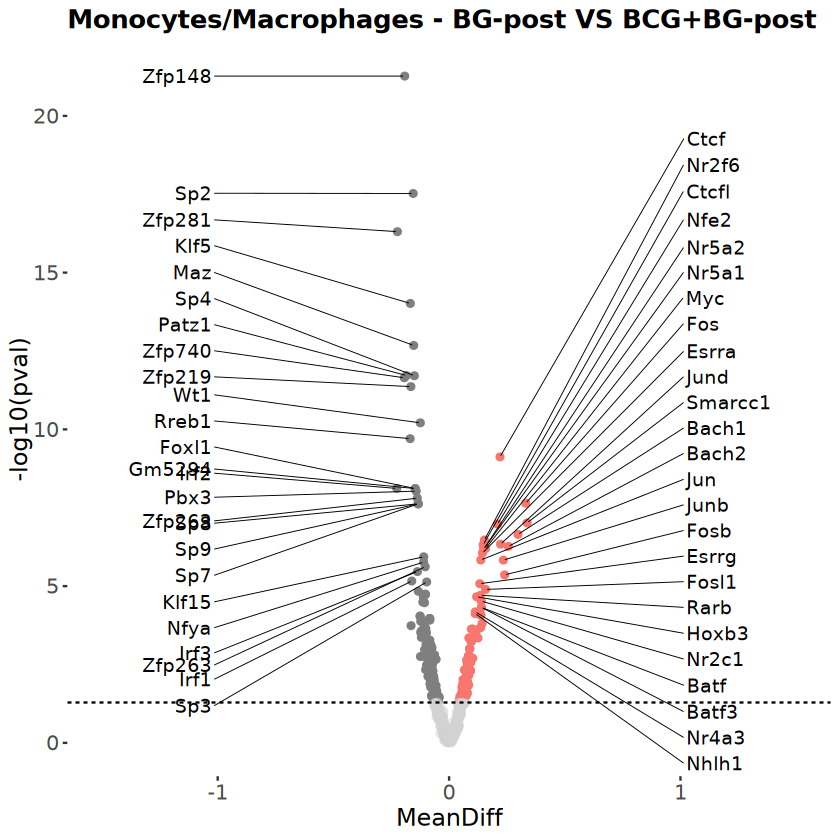

In [72]:
df <- diffchromvar[['B-Glucan-after_VS_B-Glucan-BCG-after']]

genes_to_label <- genes_to_label_function(df)

p6 <- volcanoplot(df,
            paste0(celltype,' - BG-post VS BCG+BG-post'),
            label_genes = genes_to_label,
            pval_colname = 'pval',
            FC_colname = 'MeanDiff',
            label_colname = 'name',
            ep = 1e-400,
            p_cutoff = 0.05,
            FC_cutoff = c(0,0),
            max_overlaps = 20,
            label_uplim = c(1,3),
            label_downlim = c(-1,-2),
            xlabel = 'MeanDiff',
            ylabel = '-log10(pval)') +
            xlim(-1.5,1.5)
p6

In [73]:
pdf('Monocytes_Macrophages_chromvar.pdf')
p1
p2
p3
p4
p5
p6
dev.off()

Warning message:
“Removed 159 rows containing missing values or values outside the scale range (`geom_text_repel()`).”
Warning message:
“Removed 126 rows containing missing values or values outside the scale range (`geom_text_repel()`).”
Warning message:
“ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“Removed 232 rows containing missing values or values outside the scale range (`geom_text_repel()`).”
Warning message:
“Removed 118 rows containing missing values or values outside the scale range (`geom_text_repel()`).”
Warning message:
“Removed 115 rows containing missing values or values outside the scale range (`geom_text_repel()`).”
Warning message:
“Removed 21 rows containing missing values or values outside the scale range (`geom_text_repel()`).”
Warning message:
“Removed 178 rows containing missing values or values outside the scale range (`geom_text_repel()`).”
Warning message:
“Removed 111 rows containing missing values o

pdf 
  2